In [68]:
import pandas as pd
import numpy as np
import os, sys, time
from config_bd import get_connection
from credenciales_sqlserver import *

from skops.io import dump, load, get_untrusted_types

In [69]:
with get_connection() as conn:
    query = """
    SELECT * FROM HOUSES
    """
    df = pd.read_sql(query, conn)

C:\Users\dsantamaria\AppData\Local\Temp\ipykernel_24444\3404008150.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [70]:
df

,HOUSE_ID,TITLE,PRICE,ADDRESS1,ADDRESS2,CITY,ENERGY_CONSUME,ENERGY_EMISSION,PLANTA,SUPERFICIE,...,TRASTERO,TERRAZA,BALCON,AIRE_ACOND,ORIENTACION,LATITUDE,LONGITUDE,CREATED_DATE,UPDATED_DATE,DISTRITO
0,100053144,Piso en venta en calle de Saturno,142000.0,Calle de Saturno,Barrio Casco Histórico de Barajas,"Madrid capital, Madrid",None,None,Planta 1ª,Consumo: \n260 kWh/m² año,...,False,False,False,False,None,40.473428,-3.579610,2025-05-25 16:40:39.310,2025-05-26 16:59:12.613,Barajas
1,100225591,Casa o chalet independiente en venta en calle ...,439000.0,"Calle Espliego, 17",Villalbilla,"Corredor del Henares, Madrid",None,None,2 plantas,Parcela de 710 m²,...,True,True,False,False,Orientación sur,40.444625,-3.285052,2025-05-25 16:40:39.310,2025-05-26 16:59:23.887,Not defined
2,100281275,Chalet adosado en venta en Las Matas- Peñascales,280000.0,Barrio Las Matas- Peñascales,Distrito Las Matas- Peñascales,"Zona noroeste, Madrid",None,None,2 plantas,"Emisiones: \n65,5 kg CO2/m² año",...,True,True,False,False,"Orientación sur, este, oeste",40.416728,-3.703291,2025-05-25 16:40:39.310,2025-05-26 16:59:26.273,Centro
3,100445913,Piso en venta en calle Marcelo Usera,259000.0,Calle Marcelo Usera,Barrio Moscardó,"Madrid capital, Madrid",icon-energy-c-f,icon-energy-c-f,None,"73 m² construidos, 67 m² útiles",...,False,False,False,False,"Orientación norte, sur",40.385695,-3.707122,2025-05-25 16:40:39.310,2025-05-26 17:19:30.850,Usera
4,100454896,Piso en venta en Fuentes s/n,139900.0,Fuentes s/n,Distrito Noroeste,"Corredor del Henares, Madrid",None,None,Planta 5ª exterior,63 m² construidos,...,False,False,False,False,None,40.416731,-3.703297,2025-05-25 16:40:39.310,2025-05-26 17:19:31.137,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,99447659,Piso en venta en calle de Ascao,518000.0,Calle de Ascao,Barrio Pueblo Nuevo,"Madrid capital, Madrid",None,None,Planta 1ª,"162 m² construidos, 128 m² útiles",...,False,True,False,False,None,40.431187,-3.638597,2025-05-25 16:40:39.310,2025-05-26 23:16:18.123,Ciudad Lineal
8204,99506799,"Piso en venta en calle de las Margaritas, 7",230000.0,"Calle de las Margaritas, 7",Becerril de la Sierra,"Zona noroeste, Madrid",None,None,Planta 3ª exterior,"110 m² construidos, 105 m² útiles",...,False,True,False,False,Orientación este,40.715172,-3.987483,2025-05-25 16:40:39.310,2025-05-26 23:16:18.410,Not defined
8205,99616898,"Piso en venta en calle de Andrés Mellado, 18",480000.0,"Calle de Andrés Mellado, 18",Barrio Gaztambide,"Madrid capital, Madrid",None,None,Planta 4ª interior,"40 m² construidos, 32 m² útiles",...,True,False,True,False,None,40.432178,-3.714310,2025-05-25 16:40:39.310,2025-05-26 23:16:18.690,Chamberí
8206,99904936,Piso en venta en Zaburdón - Monte Escorial,141000.0,Distrito Zaburdón - Monte Escorial,San Lorenzo de El Escorial,"Zona noroeste, Madrid",None,None,None,408 m² construidos,...,False,False,False,False,None,40.602407,-4.127118,2025-05-25 16:40:39.310,2025-05-26 23:16:18.940,Not defined


In [71]:
dp = df[['HOUSE_ID', 'HABITACIONES', 'BANOS', 'DISTRITO']].copy()
# Inicialmente filtramos los que no se ha conseguido definir el distrito
dp = dp[dp['DISTRITO']!="Not defined"].rename(columns={'HABITACIONES':'bedrooms','BANOS':'bathrooms','DISTRITO':'neighbourhood_group_cleansed'}).reset_index(drop=True)


In [72]:
dp['bedrooms'] = dp['bedrooms'].str.replace(' habitaciones','')
dp['bedrooms'] = dp['bedrooms'].str.replace(' habitación','') # for singular case
dp['bathrooms'] = dp['bathrooms'].str.replace(' baños','')
dp['bathrooms'] = dp['bathrooms'].str.replace(' baño','') # for singular case
# Quedan algunos valores con "SIN", estos con el coerce pasas a Nan
dp['bedrooms'] = pd.to_numeric(dp['bedrooms'], errors='coerce')
dp['bathrooms'] = pd.to_numeric(dp['bathrooms'], errors='coerce')
# los imputo a cero y los convierto a enteros.
dp['bedrooms'] = dp['bedrooms'].fillna(0)
dp['bathrooms'] = dp['bathrooms'].fillna(0)
dp['bedrooms'] = dp['bedrooms'].astype(int)
dp['bathrooms'] = dp['bathrooms'].astype(int)

los pinto para ver cosas raras

<Axes: title={'center': 'Number of bedrooms'}, xlabel='bedrooms'>

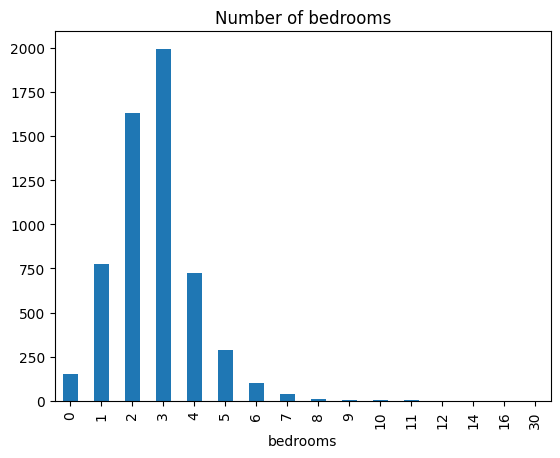

In [73]:
dp['bedrooms'].value_counts().sort_index().plot(kind='bar', title='Number of bedrooms')

<Axes: title={'center': 'Number of bathrooms'}, xlabel='bathrooms'>

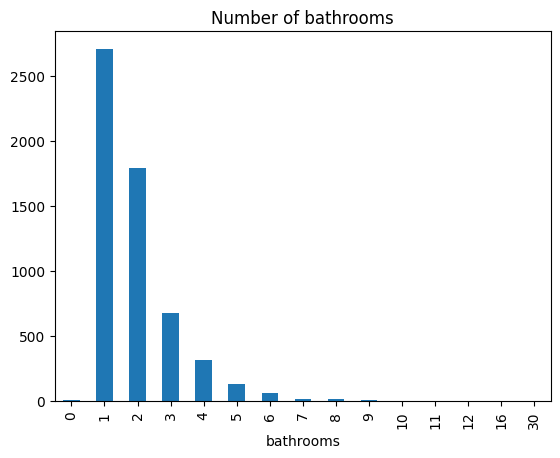

In [74]:
dp['bathrooms'].value_counts().sort_index().plot(kind='bar', title='Number of bathrooms')

In [75]:
# reviso los distritos del csv original previamente de airbnb para ver que hay coincidencia plena con los de la tabla de idealista
do = pd.read_csv('transform_listings.csv')
do['neighbourhood_group_cleansed'].value_counts().sort_index()
do['origen'] = 'airbnb'
dp['origen'] = 'idealista'
comparativa = pd.concat([do[['neighbourhood_group_cleansed', 'origen']], dp[['neighbourhood_group_cleansed', 'origen']]], ignore_index=True)
comparativa['dummy'] = 1
comparativa = comparativa.groupby(['neighbourhood_group_cleansed','origen']).agg({'dummy':'count'}).rename(columns={'dummy':'viviendas'}).reset_index()
comparativa = comparativa.pivot(index='neighbourhood_group_cleansed', columns='origen', values='viviendas').fillna(0).reset_index()
comparativa

origen,neighbourhood_group_cleansed,airbnb,idealista
0,Arganzuela,698,196
1,Barajas,54,47
2,Carabanchel,369,322
3,Centro,6586,1608
4,Chamartín,503,215
5,Chamberí,902,299
6,Ciudad Lineal,356,272
7,Fuencarral - El Pardo,131,173
8,Hortaleza,246,166
9,Latina,238,202


In [76]:
dp = dp.drop(columns=['origen'])
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   HOUSE_ID                      5733 non-null   object
 1   bedrooms                      5733 non-null   int64 
 2   bathrooms                     5733 non-null   int64 
 3   neighbourhood_group_cleansed  5733 non-null   object
dtypes: int64(2), object(2)
memory usage: 179.3+ KB


En este punto ya tenemos los datos en dp perfectamente preprocesados.

In [77]:
model_path = f"pers_models/HistGradientBoosting.skops"
untrusted = get_untrusted_types(file=model_path) #Esto es una ñapa, porque debo confiar en la función lambda de densifier
print("Untrusted:", untrusted)
model = load(model_path, trusted=untrusted)
# pred = model.predict(new_data)

Untrusted: ['sklearn._loss.link.IdentityLink', 'sklearn._loss.link.Interval', 'sklearn._loss.loss.HalfSquaredError', 'sklearn.compose._column_transformer._RemainderColsList', 'sklearn.ensemble._hist_gradient_boosting.binning._BinMapper', 'sklearn.ensemble._hist_gradient_boosting.predictor.TreePredictor']


In [78]:
import re # Required for string manipulation in extract_numeric_value

# 1. Inspeccionar el modelo para entender la estructura de entrada esperada
# El modelo es un pipeline, y su primer paso 'prep' es un ColumnTransformer.
col_transformer = model.named_steps['prep']

print("Detalles del ColumnTransformer del modelo:")
# Esta variable almacenará los nombres de las características que el modelo espera explícitamente
expected_input_features = []
for name, transformer_obj, columns in col_transformer.transformers_:
    print(f"  Transformador: {name}")
    print(f"  Se aplica a las columnas: {columns}")
    print(f"  Objeto transformador: {transformer_obj}")
    expected_input_features.extend(columns)
    print("-" * 20)


Detalles del ColumnTransformer del modelo:
  Transformador: num
  Se aplica a las columnas: ['bedrooms', 'bathrooms']
  Objeto transformador: StandardScaler()
--------------------
  Transformador: cat
  Se aplica a las columnas: ['neighbourhood_group_cleansed']
  Objeto transformador: OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
--------------------


In [79]:

#  Sabemos que el modelo espera:
# - Características numéricas: 'bedrooms', 'bathrooms' (procesadas por StandardScaler)
# - Características categóricas: 'neighbourhood_group_cleansed' (procesadas por OneHotEncoder)

# 2. Hemos preparado el DataFrame 'df' en 'dp' para que coincida con esta estructura.
# Hemos hecho lo siguiente:
#   a. Seleccionar las columnas correspondientes de 'dp'.
#   b. Convertirlas/limpiarlas según sea necesario (por ejemplo, extraer números de cadenas).
#   c. Renombrarlas a 'bedrooms', 'bathrooms', 'neighbourhood_group_cleansed'.

In [80]:
# 3. Preparar los datos para la predicción
# Asegurarse de que 'dp' tiene las columnas en el orden y con los nombres que el modelo espera.
# El modelo espera 'bedrooms', 'bathrooms', 'neighbourhood_group_cleansed'.
# 'HOUSE_ID' es solo para referencia y no debe pasarse al modelo. sino desordenamos nada, luego puedo asociar las predicciones con los IDs originales.
data_for_prediction = dp[['bedrooms', 'bathrooms', 'neighbourhood_group_cleansed']]


In [83]:
# Realizar predicciones
predictions = model.predict(data_for_prediction)
print("\nPredicciones realizadas. Ejemplo de las primeras 5 predicciones:")
print(predictions[:5])
dp['price'] = predictions




Predicciones realizadas. Ejemplo de las primeras 5 predicciones:
[122.74343582 155.44456352 128.5769773  155.44456352 193.81414654]


In [84]:
dp

,HOUSE_ID,bedrooms,bathrooms,neighbourhood_group_cleansed,price
0,100053144,3,1,Barajas,122.743436
1,100281275,3,1,Centro,155.444564
2,100445913,3,1,Usera,128.576977
3,100454896,3,1,Centro,155.444564
4,100519346,3,3,Moncloa - Aravaca,193.814147
...,...,...,...,...,...
5728,98948086,1,1,Carabanchel,79.521338
5729,99332286,4,1,Centro,171.692156
5730,99447659,4,2,Ciudad Lineal,181.397149
5731,99616898,1,1,Chamberí,106.549156


Actualizo la base de datos para almacenar la predicción (tarda unos 50-70 segundos)

In [87]:
#Cargo las predicciones a la base de datos (HE CREADO EL CAMPO PRICE_PER_NIGHT)

try:
    with get_connection() as conn:
        cursor = conn.cursor()
        # IMPORTANT: Always use parameterized queries to prevent SQL injection
        update_query = """
        UPDATE HOUSES
        SET PRICE_PER_NIGHT = ?
        WHERE HOUSE_ID = ?
        """
        for index, row in dp.iterrows():
            cursor.execute(update_query, row['price'], row['HOUSE_ID'])
        conn.commit()
        print("Predicciones actualizadas en la base de datos.")
        cursor.close()
except Exception as e:
    print(f"Error: {e}")

Predicciones actualizadas en la base de datos.


In [ ]:
with get_connection() as conn:
    query = """
    SELECT * FROM HOUSES
    """
    df = pd.read_sql(query, conn)

C:\Users\dsantamaria\AppData\Local\Temp\ipykernel_24444\2350230192.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [89]:
df

,HOUSE_ID,TITLE,PRICE,ADDRESS1,ADDRESS2,CITY,ENERGY_CONSUME,ENERGY_EMISSION,PLANTA,SUPERFICIE,...,TERRAZA,BALCON,AIRE_ACOND,ORIENTACION,LATITUDE,LONGITUDE,CREATED_DATE,UPDATED_DATE,DISTRITO,PRICE_PER_NIGHT
0,100053144,Piso en venta en calle de Saturno,142000.0,Calle de Saturno,Barrio Casco Histórico de Barajas,"Madrid capital, Madrid",None,None,Planta 1ª,Consumo: \n260 kWh/m² año,...,False,False,False,None,40.473428,-3.579610,2025-05-25 16:40:39.310,2025-05-26 16:59:12.613,Barajas,122.74
1,100225591,Casa o chalet independiente en venta en calle ...,439000.0,"Calle Espliego, 17",Villalbilla,"Corredor del Henares, Madrid",None,None,2 plantas,Parcela de 710 m²,...,True,False,False,Orientación sur,40.444625,-3.285052,2025-05-25 16:40:39.310,2025-05-26 16:59:23.887,Not defined,NaN
2,100281275,Chalet adosado en venta en Las Matas- Peñascales,280000.0,Barrio Las Matas- Peñascales,Distrito Las Matas- Peñascales,"Zona noroeste, Madrid",None,None,2 plantas,"Emisiones: \n65,5 kg CO2/m² año",...,True,False,False,"Orientación sur, este, oeste",40.416728,-3.703291,2025-05-25 16:40:39.310,2025-05-26 16:59:26.273,Centro,155.44
3,100445913,Piso en venta en calle Marcelo Usera,259000.0,Calle Marcelo Usera,Barrio Moscardó,"Madrid capital, Madrid",icon-energy-c-f,icon-energy-c-f,None,"73 m² construidos, 67 m² útiles",...,False,False,False,"Orientación norte, sur",40.385695,-3.707122,2025-05-25 16:40:39.310,2025-05-26 17:19:30.850,Usera,128.58
4,100454896,Piso en venta en Fuentes s/n,139900.0,Fuentes s/n,Distrito Noroeste,"Corredor del Henares, Madrid",None,None,Planta 5ª exterior,63 m² construidos,...,False,False,False,None,40.416731,-3.703297,2025-05-25 16:40:39.310,2025-05-26 17:19:31.137,Centro,155.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,99447659,Piso en venta en calle de Ascao,518000.0,Calle de Ascao,Barrio Pueblo Nuevo,"Madrid capital, Madrid",None,None,Planta 1ª,"162 m² construidos, 128 m² útiles",...,True,False,False,None,40.431187,-3.638597,2025-05-25 16:40:39.310,2025-05-26 23:16:18.123,Ciudad Lineal,181.40
8204,99506799,"Piso en venta en calle de las Margaritas, 7",230000.0,"Calle de las Margaritas, 7",Becerril de la Sierra,"Zona noroeste, Madrid",None,None,Planta 3ª exterior,"110 m² construidos, 105 m² útiles",...,True,False,False,Orientación este,40.715172,-3.987483,2025-05-25 16:40:39.310,2025-05-26 23:16:18.410,Not defined,NaN
8205,99616898,"Piso en venta en calle de Andrés Mellado, 18",480000.0,"Calle de Andrés Mellado, 18",Barrio Gaztambide,"Madrid capital, Madrid",None,None,Planta 4ª interior,"40 m² construidos, 32 m² útiles",...,False,True,False,None,40.432178,-3.714310,2025-05-25 16:40:39.310,2025-05-26 23:16:18.690,Chamberí,106.55
8206,99904936,Piso en venta en Zaburdón - Monte Escorial,141000.0,Distrito Zaburdón - Monte Escorial,San Lorenzo de El Escorial,"Zona noroeste, Madrid",None,None,None,408 m² construidos,...,False,False,False,None,40.602407,-4.127118,2025-05-25 16:40:39.310,2025-05-26 23:16:18.940,Not defined,NaN
